# Dataset Information Creation
Create a json file to represent the files inside the dataset

In [9]:
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import numpy as np
import json
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
from models.vanilla_cnn import AudioCNN
import torch.nn as nn
from utils import specs_generation, collect_samples
import os

In [10]:
# sudo modprobe nvidia_uvm
torch.cuda.is_available()

True

In [11]:
DATASET_NAME = "DATASET_CNN"
DATASET_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}'
TRAIN_PATH = f"{DATASET_PATH}/train"
TEST_PATH = f"{DATASET_PATH}/test"
MODEL_NAME = 'vanilla_cnn'

# Create Dataset Config

In [12]:
test_species = os.listdir(TEST_PATH) 

In [13]:
with open("utils/category_annots.json") as f:
    category_annots = json.load(f)

filtered_species = [species for species in category_annots.keys() if len(species.split("_")) > 1 and species in test_species]
mappings = {species: i for i, species in enumerate(filtered_species)}
mappings

{'Regulus ignicapilla_Common Firecrest': 0,
 'Sylvia atricapilla_Eurasian Blackcap': 1,
 'Fringilla coelebs_Common Chaffinch': 2,
 'Troglodytes troglodytes_Eurasian Wren': 3,
 'Muscicapa striata_Spotted Flycatcher': 4,
 'Glaucidium passerinum_Eurasian Pygmy-Owl': 5,
 'Pyrrhula pyrrhula_Eurasian Bullfinch': 6,
 'Periparus ater_Coal Tit': 7,
 'Lophophanes cristatus_Crested Tit': 8,
 'Regulus regulus_Goldcrest': 9,
 'Turdus merula_Eurasian Blackbird': 10,
 'Certhia familiaris_Eurasian Treecreeper': 11,
 'Erithacus rubecula_European Robin': 12,
 'Turdus philomelos_Song Thrush': 13,
 'Loxia curvirostra_Common Crossbill': 14,
 'Dendrocopos major_Great Spotted Woodpecker': 15,
 'Dryocopus martius_Black Woodpecker': 16}

In [14]:
samples = collect_samples(TRAIN_PATH, TEST_PATH, mappings)

In [15]:
dataset_config = {
    "mappings": mappings,
    "samples": samples
}

In [16]:
with open(f"utils/{DATASET_NAME}/dataset_config.json", "w") as f:
    json.dump(dataset_config, f)

# Spectograms Creation

In [32]:
import os
import torchaudio
import torch
import torch.nn.functional as F

def specs_generation(input_path, output_path, mappings):
    sample_rate = 32000
    target_samples = sample_rate * 3
    n_fft = 1024
    hop_length = 256
    win_length = 1024

    for species in os.listdir(input_path):
        if species not in mappings:
            continue
        species_path = os.path.join(input_path, species)
        output_species_path = os.path.join(output_path, species)
        os.makedirs(output_species_path, exist_ok=True)

        print(f"Processing: {species}")

        for audio in os.listdir(species_path):
            audio_name = os.path.splitext(audio)[0]
            save_path = os.path.join(output_species_path, f"{audio_name}.pt")
            if os.path.exists(save_path):
                continue
            audio_path = os.path.join(species_path, audio)
            waveform, sr = torchaudio.load(audio_path)

            if sr != sample_rate:
                resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
                waveform = resampler(waveform)

            if waveform.shape[1] < target_samples:
                pad_len = target_samples - waveform.shape[1]
                waveform = F.pad(waveform, (0, pad_len))
            else:
                waveform = waveform[:, :target_samples]

            waveform = waveform[0:1, :]  # keep solo il primo canale

            window = torch.hann_window(n_fft, device=waveform.device)

            stft = torch.stft(
                waveform,
                n_fft=n_fft,
                hop_length=hop_length,
                win_length=win_length,
                window=window,
                return_complex=True
            )
            spectrogram = torch.abs(stft)  # shape: (freq, time)

            # Optional log scaling or 
            spectrogram = torch.log1p(spectrogram)
            # spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())

            # Resize to 256x256
            spectrogram = spectrogram.unsqueeze(0) # (1, 1, freq, time)
            spectrogram = F.interpolate(spectrogram, size=(256, 256), mode="bilinear", align_corners=False)
            spectrogram = spectrogram.squeeze(0).squeeze(0)  # torna a (256, 256)

            # Save the spectrogram tensor
            torch.save(spectrogram, save_path)

In [33]:
SPECS_TRAIN_PATH = f"{DATASET_PATH}/train_specs"
SPECS_TEST_PATH = f"{DATASET_PATH}/test_specs"
os.makedirs(SPECS_TRAIN_PATH, exist_ok=True)
os.makedirs(SPECS_TEST_PATH, exist_ok=True)
specs_generation(TRAIN_PATH, SPECS_TRAIN_PATH, dataset_config['mappings'])
specs_generation(TEST_PATH, SPECS_TEST_PATH, dataset_config['mappings'])

Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulus_Goldcrest
Processing: Glaucidium passerinum_Eurasian Pygmy-Owl
Processing: Troglodytes troglodytes_Eurasian Wren
Processing: Erithacus rubecula_European Robin
Processing: Dryocopus martius_Black Woodpecker
Processing: Certhia familiaris_Eurasian Treecreeper
Processing: Pyrrhula pyrrhula_Eurasian Bullfinch
Processing: Turdus merula_Eurasian Blackbird
Processing: Loxia curvirostra_Common Crossbill
Processing: Regulus ignicapilla_Common Firecrest
Processing: Dendrocopos major_Great Spotted Woodpecker
Processing: Sylvia atricapilla_Eurasian Blackcap
Processing: Lophophanes cristatus_Crested Tit
Processing: Fringilla coelebs_Common Chaffinch
Processing: Turdus philomelos_Song Thrush
Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulus_Goldcrest
Processing: Glaucidium passerinum_Eurasian Pygmy-Owl
Processing: Troglodytes 

Shape: torch.Size([256, 256])


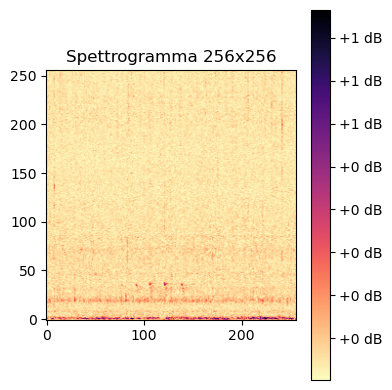

In [35]:
# carica lo spettrogramma salvato
spec_path = "/home/giacomoschiavo/segments/DATASET_CNN/train_specs/Turdus merula_Eurasian Blackbird/20190621_160000_64_5.pt"  # cambia path se serve
spec = torch.load(spec_path)

# controlla la shape per capire cosa stai guardando
print("Shape:", spec.shape)  # dovrebbe essere (256, 256)

# Plot semplice e clean
plt.figure(figsize=(4, 4))
plt.imshow(spec.numpy(), origin='lower', cmap='magma_r')
plt.title("Spettrogramma 256x256")
plt.colorbar(format="%+2.f dB")
plt.tight_layout()
plt.show()


# Dataset and Data Loader
Use the dataset information to create a data loader for the model

In [36]:
def wav_to_spec(audio_path):
    split = audio_path.split("/")[-3]
    audio = audio_path.replace("wav", "pt").replace(split, f"{split}_specs")
    return audio

In [37]:
class CachedAudioDataset(Dataset):
    def __init__(self, dataset_config, split="train"):
        self.samples = [s for s in dataset_config["samples"] if s["split"] == split]
        self.num_classes = len(dataset_config["mappings"])
        
        # Carica tutto in RAM
        self.cache = []
        for sample in self.samples:
            spec = torch.load(wav_to_spec(sample["file_path"]))  # spettrogramma
            label_tensor = torch.zeros(self.num_classes)
            for label in sample["labels"]:
                label_tensor[label] = 1.0
            self.cache.append((spec, label_tensor, sample["file_path"]))

    def __len__(self):
        return len(self.cache)

    def __getitem__(self, idx):
        return self.cache[idx]


In [38]:
from torch.utils.data import DataLoader

def get_dataloader(dataset_config, split="train", batch_size=100, shuffle=True):
    dataset = CachedAudioDataset(dataset_config=dataset_config, split=split)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Model

In [39]:
def train_model(dataset_config, model_name, epochs=10, batch_size=100, lr=0.00001, print_freq=100):
    history_loss = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")

    print("Loading training data...")
    train_loader = get_dataloader(dataset_config, split="train", batch_size=batch_size)
    print("Loaded!")
    num_classes = len(dataset_config['mappings'])

    model = AudioCNN(num_classes).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    saving_path = f'models/saved_checkpoints/{model_name}_checkpoint.pth'
    if os.path.exists(saving_path):
        checkpoint = torch.load(saving_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(f"\n🎯 Starting epoch {epoch + 1}/{epochs}")

        for batch_index, (mel_spec, labels, _) in enumerate(train_loader):
            mel_spec = mel_spec.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if batch_index % print_freq == 0:
                print('Epoch: [{0}][{1}/{2}], Loss: {loss:.5f}'.format(epoch, batch_index, len(train_loader), loss=loss))

        avg_loss = running_loss / len(train_loader)
        history_loss.append(running_loss)

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, f"models/saved_checkpoints/{model_name}_checkpoint.pth")

    print("✅ Training completed")
    return model, history_loss


In [41]:
model, history_loss = train_model(dataset_config, MODEL_NAME, epochs=10, batch_size=25, lr=1e-5)

Training on: cuda
Loading training data...
Loaded!

🎯 Starting epoch 1/10
Epoch: [0][0/721], Loss: 0.70386
Epoch: [0][100/721], Loss: 0.69183
Epoch: [0][200/721], Loss: 0.66146
Epoch: [0][300/721], Loss: 0.57544
Epoch: [0][400/721], Loss: 0.42875
Epoch: [0][500/721], Loss: 0.30701
Epoch: [0][600/721], Loss: 0.28495
Epoch: [0][700/721], Loss: 0.27373

🎯 Starting epoch 2/10
Epoch: [1][0/721], Loss: 0.27710
Epoch: [1][100/721], Loss: 0.24490
Epoch: [1][200/721], Loss: 0.22879
Epoch: [1][300/721], Loss: 0.26866
Epoch: [1][400/721], Loss: 0.26033
Epoch: [1][500/721], Loss: 0.23200
Epoch: [1][600/721], Loss: 0.28985
Epoch: [1][700/721], Loss: 0.25213

🎯 Starting epoch 3/10
Epoch: [2][0/721], Loss: 0.24284
Epoch: [2][100/721], Loss: 0.21113
Epoch: [2][200/721], Loss: 0.25600
Epoch: [2][300/721], Loss: 0.24975
Epoch: [2][400/721], Loss: 0.27379
Epoch: [2][500/721], Loss: 0.23155
Epoch: [2][600/721], Loss: 0.23362
Epoch: [2][700/721], Loss: 0.26180

🎯 Starting epoch 4/10
Epoch: [3][0/721], Loss

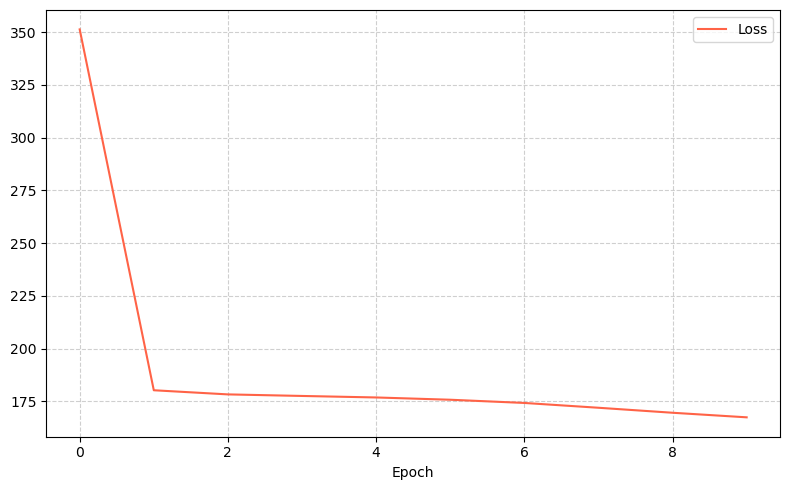

In [43]:
plt.figure(figsize=(8, 5))
plt.plot(history_loss, linestyle='-', color='tomato', label="Loss")
# plt.title(title)
plt.xlabel("Epoch")
# plt.ylabel(ylabel)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
from sklearn.metrics import classification_report, roc_auc_score, multilabel_confusion_matrix
import numpy as np

def test_model(model, dataset_config, batch_size=100, threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n🧬 Advanced testing on: {device}")

    test_loader = get_dataloader(dataset_config, split="test", batch_size=batch_size, shuffle=False)
    model.eval()
    criterion = nn.BCEWithLogitsLoss()

    total_loss = 0.0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for mel_spec, labels, _ in test_loader:
            mel_spec = mel_spec.to(device)
            labels = labels.to(device)

            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / len(test_loader)
    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # 👇 Report
    clf_report = classification_report(all_labels, all_preds, target_names=dataset_config["mappings"], zero_division=0, output_dict=True)

    # 🎯 ROC AUC (solo se c'è più di una classe positiva per classe)
    # try:
    #     auc = roc_auc_score(all_labels, all_probs, average='macro')
    #     print(f"🩸 Macro AUC: {auc:.4f}")
    # except ValueError:
    #     print("⚠️  AUC non calcolabile: alcune classi hanno solo 0 nei label.")

    # # 💥 Confusion Matrix per ogni classe
    # cm = multilabel_confusion_matrix(all_labels, all_preds)
    # for idx, label in enumerate(dataset_config["mappings"]):
    #     tn, fp, fn, tp = cm[idx].ravel()
    #     print(f"\n🔍 Classe: {label}")
    #     print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

    return avg_loss, clf_report, all_probs, all_labels, all_preds


In [45]:
avg_loss, clf_report, all_probs, all_labels, all_preds = test_model(model, dataset_config, threshold=0.2)


🧬 Advanced testing on: cuda


In [46]:
from io import StringIO
import pandas as pd

clf_report_df = pd.read_json(StringIO(json.dumps(clf_report)), orient='index')
clf_report_df

,precision,recall,f1-score,support
Regulus ignicapilla_Common Firecrest,0.133779,0.145808,0.139535,823
Sylvia atricapilla_Eurasian Blackcap,0.306360,0.600000,0.405614,1445
Fringilla coelebs_Common Chaffinch,0.709126,0.951887,0.812767,2702
Troglodytes troglodytes_Eurasian Wren,0.000000,0.000000,0.000000,149
Muscicapa striata_Spotted Flycatcher,0.000000,0.000000,0.000000,159
Glaucidium passerinum_Eurasian Pygmy-Owl,0.000000,0.000000,0.000000,27
Pyrrhula pyrrhula_Eurasian Bullfinch,0.000000,0.000000,0.000000,31
Periparus ater_Coal Tit,0.000000,0.000000,0.000000,151
Lophophanes cristatus_Crested Tit,0.000000,0.000000,0.000000,43
Regulus regulus_Goldcrest,0.000000,0.000000,0.000000,142


In [42]:
# [0.23355515, 0.2993289 , 0.48187926, 0.09644947, 0.02646333,
#  0.00338182, 0.0060347 , 0.02764585, 0.00980125, 0.04588749,
#  0.01456839, 0.01318356, 0.10734965, 0.31234452, 0.01319104,
#  0.00400275, 0.00610506]

In [47]:
index = 3
all_probs[index], all_labels[index], all_preds[index]

(array([0.20168103, 0.22134638, 0.45067653, 0.06884308, 0.02334619,
        0.00119458, 0.00376901, 0.06449208, 0.02082955, 0.04610636,
        0.04268059, 0.02239683, 0.08196513, 0.26924425, 0.01399249,
        0.02268158, 0.00753866], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       dtype=float32),
 array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       dtype=float32))